In [15]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [5]:
log_pr.corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.006817,0.014591,-0.417482,0.018413,-0.606621,-0.430977,-0.204252,0.390427,0.509034
1,-0.006817,1.000000,-0.962004,-0.478094,0.930129,0.603047,0.699573,0.904888,-0.471109,0.406553
2,0.014591,-0.962004,1.000000,0.445416,-0.949755,-0.558964,-0.699778,-0.929719,0.421475,-0.508475
3,-0.417482,-0.478094,0.445416,1.000000,-0.421924,-0.235051,-0.328136,-0.291929,0.304858,-0.215146
4,0.018413,0.930129,-0.949755,-0.421924,1.000000,0.469946,0.668906,0.871155,-0.283197,0.556515
5,-0.606621,0.603047,-0.558964,-0.235051,0.469946,1.000000,0.793019,0.581784,-0.795475,-0.357198
6,-0.430977,0.699573,-0.699778,-0.328136,0.668906,0.793019,1.000000,0.680256,-0.537370,-0.044261
7,-0.204252,0.904888,-0.929719,-0.291929,0.871155,0.581784,0.680256,1.000000,-0.469843,0.414800
8,0.390427,-0.471109,0.421475,0.304858,-0.283197,-0.795475,-0.537370,-0.469843,1.000000,0.405374
9,0.509034,0.406553,-0.508475,-0.215146,0.556515,-0.357198,-0.044261,0.414800,0.405374,1.000000


In [42]:
log_pr.std()

0    0.215493
1    0.277740
2    0.618049
3    0.136871
4    0.138968
5    0.205220
6    0.100223
7    0.146638
8    0.063862
9    0.101024
dtype: float64

***Different assets should have different weights of prediction in the results because highly variated signals contribute more to the overall correlations. Assets that need more accuracy of prediction over the others are, in decreasing order of importance, 2, 1, 0, 5).***

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

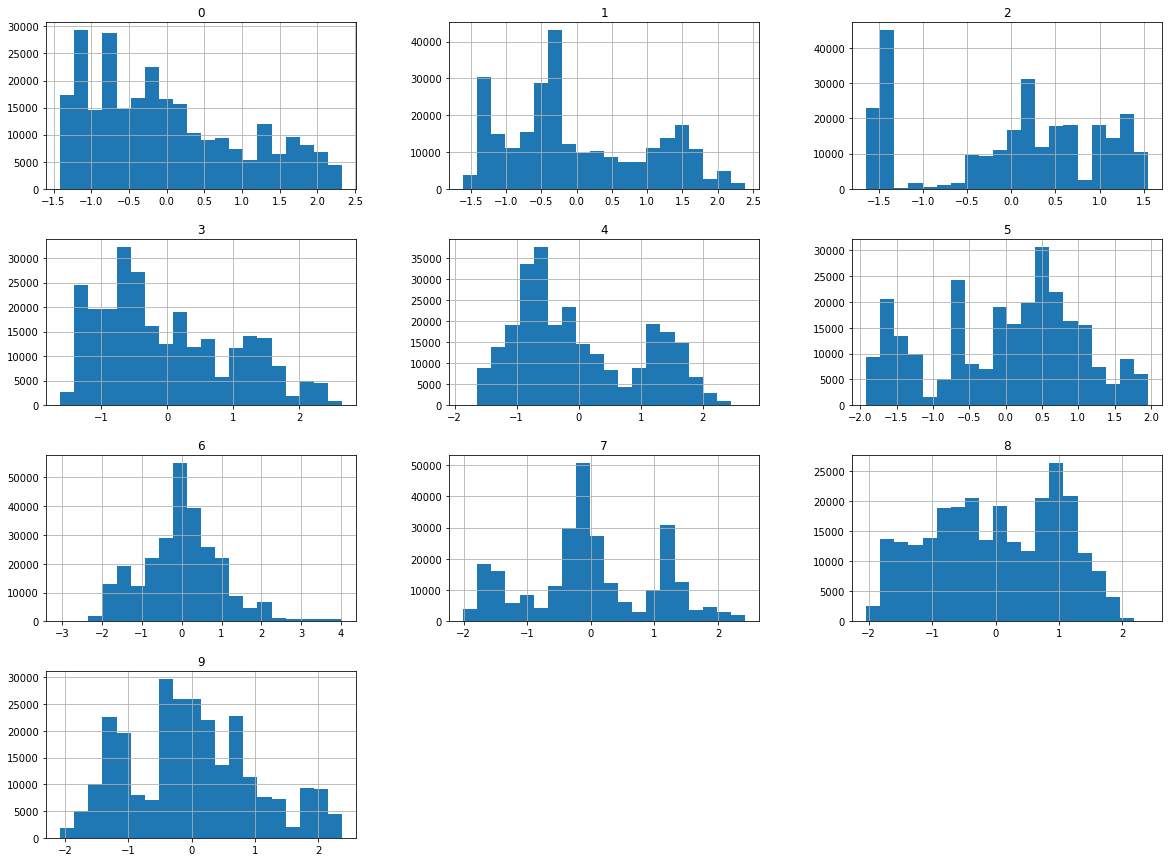

In [51]:
((log_pr - log_pr.mean())/log_pr.std()).hist(bins=20, figsize=(20, 15))

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

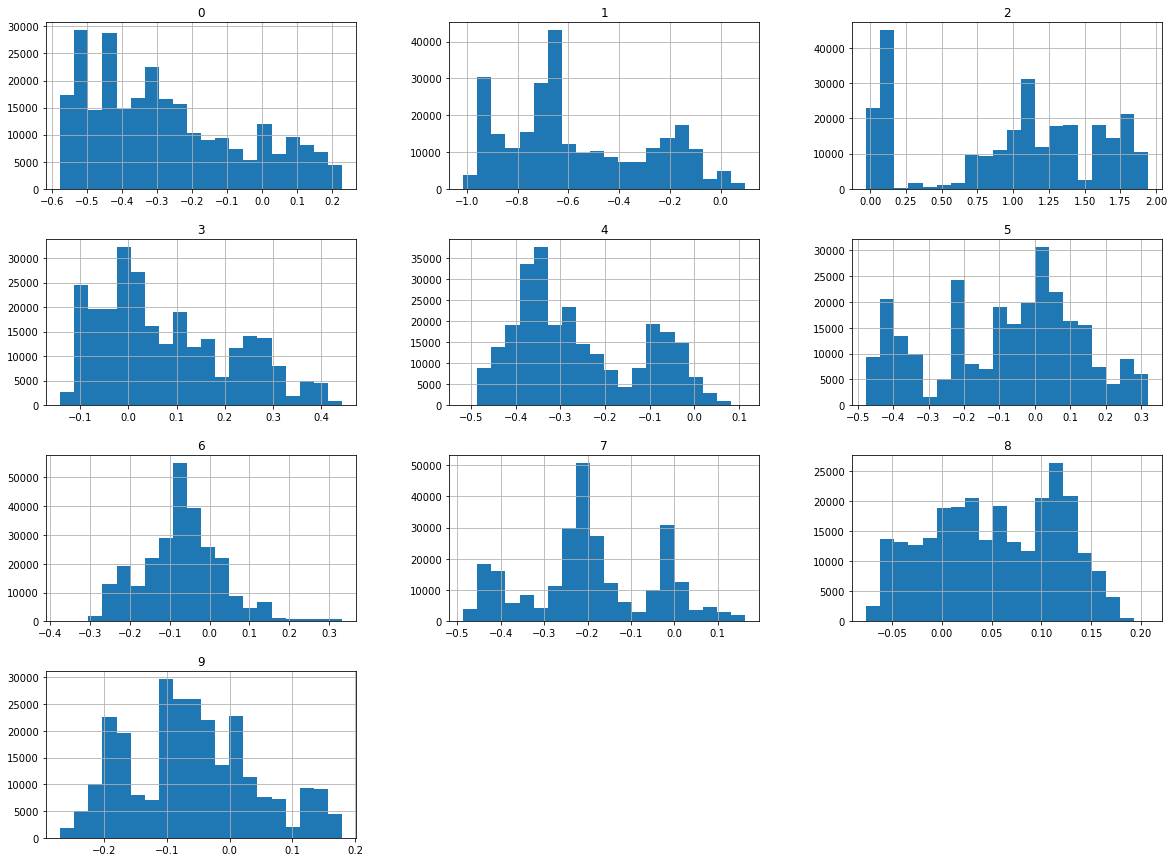

In [52]:
log_pr.hist(figsize=(20, 15), bins=20)

In [24]:
lags = 30
for i in range(10):
    print("auto correlation for asset %d:"%i, log_pr[i].autocorr(lag=lags))

auto correlation for asset 0: 0.9996248561581881
auto correlation for asset 1: 0.99975356651825
auto correlation for asset 2: 0.9999121508390441
auto correlation for asset 3: 0.9993631397233164
auto correlation for asset 4: 0.9995033885558238
auto correlation for asset 5: 0.9998003645419574
auto correlation for asset 6: 0.9991207579855245
auto correlation for asset 7: 0.9997059468809676
auto correlation for asset 8: 0.9989293730987598
auto correlation for asset 9: 0.9995581009521974


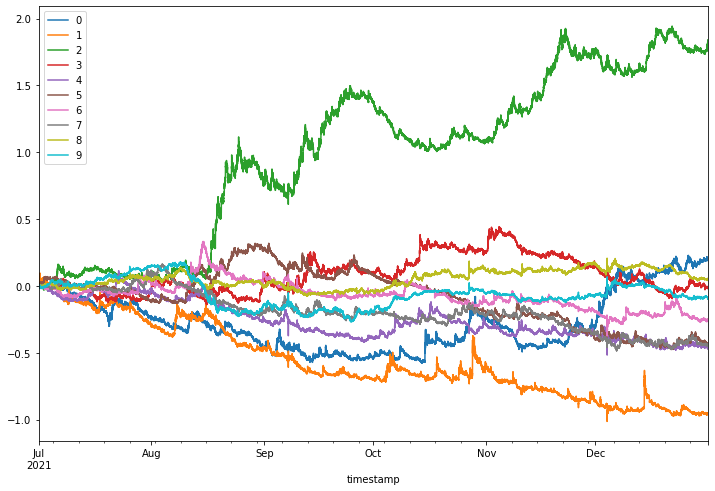

In [5]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))
plt.show()


In [92]:
def BollingerBands(data:pd.DataFrame, window_size):
    ma = data.rolling(window=window_size).mean()
    sd = data.rolling(window=window_size).std()
    up = ma + 2*sd
    down = ma - 2*sd
    return up, down

Combined assets: 2, 0, 3, (8,9), (1,6), (4,5,7)

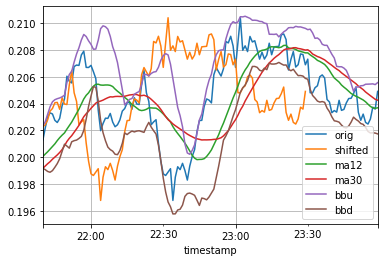

In [94]:
df = pd.concat([log_pr[0], log_pr.shift(-30)[0], log_pr.rolling(20).mean()[0], log_pr.rolling(30).mean()[0], *BollingerBands(log_pr[0], 12)], axis=1)
df.columns=["orig", "shifted", "ma12", "ma30", "bbu", "bbd"]
df[-140:].plot()
plt.grid()

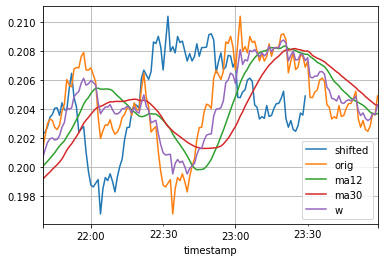

In [85]:
ds = pd.concat([df, pd.DataFrame((df["ma12"] + df["orig"])/2, columns=["w"])], axis=1)
ds[["shifted", "orig", "ma12", "ma30", 'w']][-140:].plot()
plt.grid()

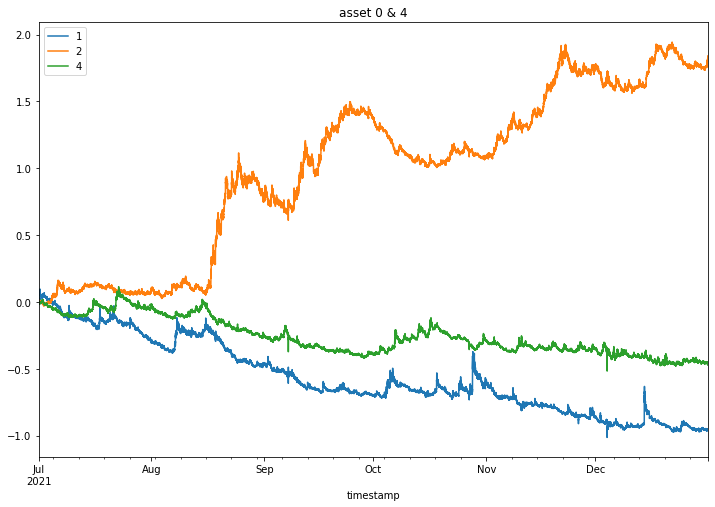

In [21]:
log_pr[[1, 2, 4]].plot(figsize=(12, 8), title="asset 0 & 4")
plt.show()

In [12]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9

    """
    A  =A.values.T
    for i in range(10):
        features = np.empty((1440),dtype=complex)
        fourier = a
    
    return (A.iloc[-30] - A.iloc[-1]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [4]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

8.745189428329468


In [5]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [6]:
# Correlation for every asset

r_fwd.corrwith(r_hat), r_fwd.corrwith(r_hat).mean()

(0    0.028584
 1    0.063681
 2    0.005824
 3    0.036314
 4    0.096442
 5    0.035261
 6    0.067607
 7    0.022329
 8    0.105946
 9    0.053176
 dtype: float64,
 0.05151638966522602)

In [7]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

0.040118694541047606

In [16]:
import ojsim
sim = ojsim.OJSimulator()
sim.submit(get_r_hat)

100%|██████████| 8496/8496 [00:10<00:00, 847.30it/s]

Total time used: 10.030s
Pairwise correlation:
	asset 0 = 0.00464
	asset 1 = 0.09289
	asset 2 = -0.02409
	asset 3 = 0.01298
	asset 4 = 0.03995
	asset 5 = 0.04371
	asset 6 = 0.04108
	asset 7 = 0.00118
	asset 8 = 0.05952
	asset 9 = 0.03886
	mean correlation = 0.03107
Overall correlation: 0.02361
Performance beats Ziwei's dummy method!


(10.030186176300049,
 0    0.004636
 1    0.092891
 2   -0.024087
 3    0.012980
 4    0.039951
 5    0.043706
 6    0.041076
 7    0.001180
 8    0.059518
 9    0.038859
 dtype: float64,
 0.02360880014885631)

In [18]:
a = np.random.randn(1000, 10)

In [24]:
b = np.sign(a)

In [25]:
np.corrcoef(a.ravel(), b.ravel())

array([[1.       , 0.7995446],
       [0.7995446, 1.       ]])

In [1]:
import ojsim
sim = ojsim.OJSimulator()
import main
from critic import Critic
cr = Critic()
cr.submit(main.get_r_hat, sim.dataset.log_pr, sim.dataset.volu)

100%|██████████| 26352/26352 [00:23<00:00, 1102.17it/s]


Total time used: 23.949s
Pairwise correlation:
	asset 0 = 0.02850
	asset 1 = 0.06364
	asset 2 = 0.00575
	asset 3 = 0.03635
	asset 4 = 0.09649
	asset 5 = 0.03564
	asset 6 = 0.06740
	asset 7 = 0.02191
	asset 8 = 0.10574
	asset 9 = 0.05275
	mean correlation = 0.05142
Overall correlation: 0.04000
Performance beats Ziwei's dummy method!


(23.948550939559937,
 0    0.028499
 1    0.063642
 2    0.005750
 3    0.036351
 4    0.096490
 5    0.035639
 6    0.067398
 7    0.021906
 8    0.105735
 9    0.052748
 dtype: float64,
 0.04000208155756053)

In [8]:
def get_r_hat(A, B):
    ma = A.rolling(11).mean().values[-1] - A.values[-1]
    zw = (A.iloc[-30] - A.iloc[-1]).values
    return (ma + zw) / 2

import ojsim
sim = ojsim.OJSimulator()
sim.submit(get_r_hat)

100%|██████████| 8496/8496 [00:11<00:00, 757.13it/s]

Total time used: 11.224s
Pairwise correlation:
	asset 0 = 0.00729
	asset 1 = 0.07669
	asset 2 = -0.02741
	asset 3 = 0.00688
	asset 4 = 0.05704
	asset 5 = 0.02037
	asset 6 = 0.04884
	asset 7 = -0.00181
	asset 8 = 0.07976
	asset 9 = 0.06510
	mean correlation = 0.03327
Overall correlation: 0.02219
Performance beats Ziwei's dummy method!


(11.224265813827515,
 0    0.007286
 1    0.076689
 2   -0.027408
 3    0.006878
 4    0.057043
 5    0.020370
 6    0.048840
 7   -0.001805
 8    0.079756
 9    0.065101
 dtype: float64,
 0.02219206733378322)

In [14]:
def get_r_hat(A, B):
    ma = A.rolling(30).mean().values
    return ma[-1] - A.values[-1]

import ojsim
sim = ojsim.OJSimulator()
sim.submit(get_r_hat)

100%|██████████| 8496/8496 [00:10<00:00, 814.57it/s]

Total time used: 10.434s
Pairwise correlation:
	asset 0 = 0.00464
	asset 1 = 0.09289
	asset 2 = -0.02409
	asset 3 = 0.01298
	asset 4 = 0.03995
	asset 5 = 0.04371
	asset 6 = 0.04108
	asset 7 = 0.00118
	asset 8 = 0.05952
	asset 9 = 0.03886
	mean correlation = 0.03107
Overall correlation: 0.02361
Performance beats Ziwei's dummy method!


(10.434044122695923,
 0    0.004636
 1    0.092891
 2   -0.024087
 3    0.012980
 4    0.039951
 5    0.043706
 6    0.041076
 7    0.001180
 8    0.059518
 9    0.038859
 dtype: float64,
 0.02360880014885631)

In [2]:
28 * 24 / 60

11.2